In [1]:
# import modules
from glob import glob
import os,sys
import numpy as np
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import matplotlib.colors as col
import matplotlib.cm as cm
import matplotlib.colorbar as cb
import cv2

My code:

In [2]:
# cut at Southern Ocean boundary and define contour depth:
lat_north = -59.
contour_depth = 1500

In [3]:
model_dir = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/'
gridFileList = sorted(glob(os.path.join(model_dir, 'output*/ocean/ocean_grid.nc')))
grid_file = gridFileList[0]
print(grid_file)

/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc


In [4]:
gridFile = nc.Dataset(grid_file)
xu_ocean = gridFile.variables['xu_ocean'][...]
yu_ocean = gridFile.variables['yu_ocean'][...]

#restrict to south of Southern Ocean cut-off
north_index = (np.abs(yu_ocean-lat_north)).argmin()
yu_ocean = yu_ocean[:north_index]
yu_ocean.shape
lon_c = gridFile.variables['geolon_c'][:north_index,:]
lat_c = gridFile.variables['geolat_c'][:north_index,:]
hu = gridFile.variables['hu'][:north_index,:]
land_mask = np.copy(hu)
land_mask[np.where(hu>30)] = 0  # Q to follow up: Why 30 and not NAN?
land_mask[np.where(hu<30)] = 1

print('Finding depth contour')

Finding depth contour


In [120]:
temp_mask = np.copy(hu)
temp_mask[np.where(hu>contour_depth)] = 0
temp_mask[np.where(hu<=contour_depth)] = 1

# this spreads the isobath contour so all points are connected adjacently (not just 
# diagonally):
kernel = np.ones((3,3),np.uint8)
contour_mask0 = cv2.dilate(temp_mask,kernel,iterations=1) - temp_mask
print(contour_mask0.shape, contour_mask0.min(), contour_mask0.max())

(509, 3600) 0.0 1.0


In [121]:
# start at western edge of domain, at y point closest to correct depth contour:
contour_mask = np.zeros_like(land_mask)
contour_lat_index_start = np.where(contour_mask0[:,0]>0)[0][0]
contour_mask[contour_lat_index_start,0] = 1

In [123]:
# loop through to find adjacent point closest to 1000m depth (not inc previous point):
last_index_i = 0
last_index_j = contour_lat_index_start
count = 0
while last_index_i<3599:
    # first time don't go backwards:
    if last_index_i == 0:
        points_to_compare = np.array([contour_mask0[last_index_j,last_index_i+1],
                                      0,
                                      contour_mask0[last_index_j+1,last_index_i],
                                      contour_mask0[last_index_j-1,last_index_i]])
    else:
        points_to_compare = np.array([contour_mask0[last_index_j,last_index_i+1],
                                     contour_mask0[last_index_j,last_index_i-1],
                                     contour_mask0[last_index_j+1,last_index_i],
                                     contour_mask0[last_index_j-1,last_index_i]])

    new_loc = np.where(points_to_compare==1)[0]

    # this gives each point along contour a unique index number:
    if len(new_loc)==0:
        contour_mask[last_index_j,last_index_i] = 0
        contour_mask0[last_index_j,last_index_i] = 0
        #contour_mask0[contour_mask==count] = 0
        #print('j'+str(last_index_j)+'i'+str(last_index_i))
        count = count - 1
        last_index_i = np.where(contour_mask==count+1)[1]
        last_index_j = np.where(contour_mask==count+1)[0]
        continue
    elif len(new_loc)>0:
        if new_loc[0] == 0:
            new_index_i = last_index_i+1
            new_index_j = last_index_j
        elif new_loc[0] == 1:
            new_index_i = last_index_i-1
            new_index_j = last_index_j
        elif new_loc[0] == 2:
            new_index_i = last_index_i
            new_index_j = last_index_j+1
        elif new_loc[0] == 3:
            new_index_i = last_index_i
            new_index_j = last_index_j-1
        contour_mask[new_index_j,new_index_i] = count + 2
        contour_mask0[last_index_j,last_index_i] = 2
        last_index_j = new_index_j
        last_index_i = new_index_i
        count += 1

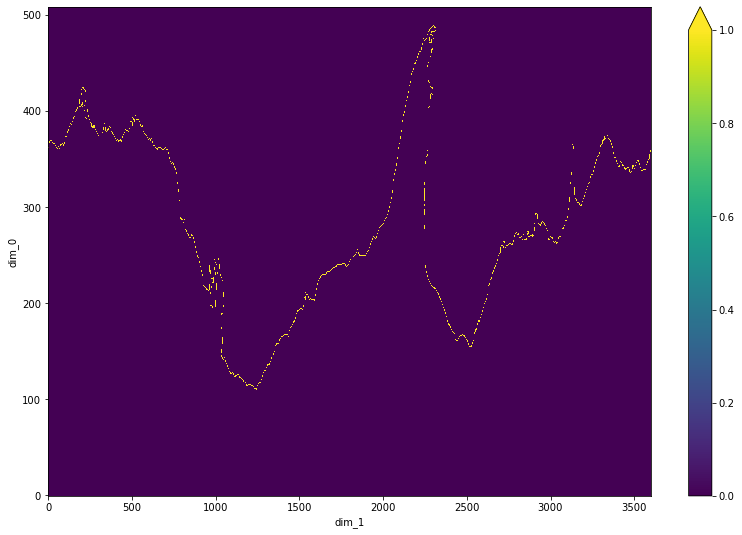

In [124]:
contour_mask0.shape
a = xr.DataArray(contour_mask)
a.plot(size= 9, vmin=0, vmax=1)

In [125]:
contour_mask_numbered = contour_mask

In [126]:
contour_masked_above = np.copy(contour_mask_numbered)
#contour_masked_above[-1,0] = -100

In [127]:
######################
# fill in points to north of contour:
print('Floodfilling above contour')

contour_masked_above = np.copy(contour_mask_numbered)
contour_masked_above[-1,0] = -100

# from top left:
for ii in range(len(xu_ocean)-1):
    for jj in range(len(yu_ocean))[::-1][:-1]:
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj-1,ii] == 0:
                contour_masked_above[jj-1,ii] = -100
            if contour_masked_above[jj,ii+1] == 0:
                contour_masked_above[jj,ii+1] = -100
            if contour_masked_above[jj-1,ii+1] == 0:
                contour_masked_above[jj-1,ii+1] = -100
# from top right:
for ii in range(len(xu_ocean))[::-1][:-1]:
    for jj in range(len(yu_ocean))[::-1][:-1]:
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj-1,ii] == 0:
                contour_masked_above[jj-1,ii] = -100
            if contour_masked_above[jj,ii-1] == 0:
                contour_masked_above[jj,ii-1] = -100
            if contour_masked_above[jj-1,ii-1] == 0:
                contour_masked_above[jj-1,ii-1] = -100
# from bottom right:
for ii in range(len(xu_ocean))[::-1][:-1]:
    for jj in range(len(yu_ocean)-1):
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj+1,ii] == 0:
                contour_masked_above[jj+1,ii] = -100
            if contour_masked_above[jj,ii-1] == 0:
                contour_masked_above[jj,ii-1] = -100
            if contour_masked_above[jj+1,ii-1] == 0:
                contour_masked_above[jj+1,ii-1] = -100
# from bottom left:
for ii in range(len(xu_ocean)-1):
    for jj in range(len(yu_ocean)-1):
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj+1,ii] == 0:
                contour_masked_above[jj+1,ii] = -100
            if contour_masked_above[jj,ii+1] == 0:
                contour_masked_above[jj,ii+1] = -100
            if contour_masked_above[jj+1,ii+1] == 0:
                contour_masked_above[jj+1,ii+1] = -100

Floodfilling above contour


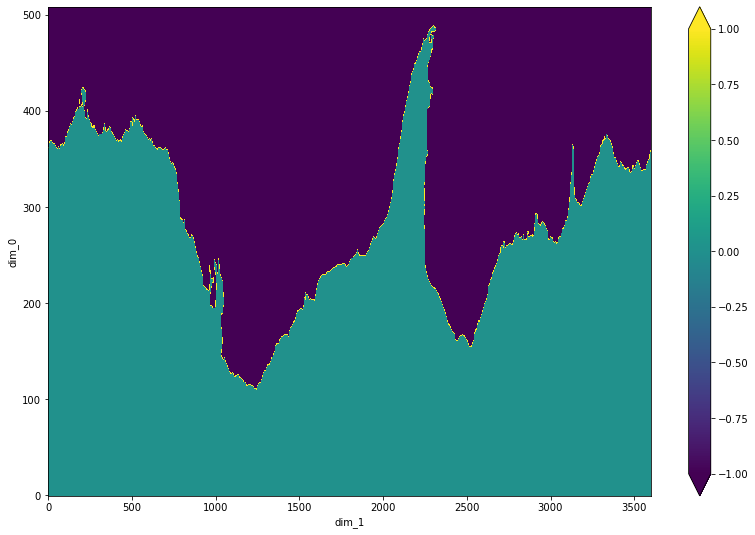

In [128]:
b = xr.DataArray(contour_masked_above)
b.plot(size= 9, vmin=-1, vmax=1)

In [129]:
shelf_mask_1 = xr.where(b==-100, np.nan, 1)

In [130]:
shelf_mask_2 = shelf_mask_1.rename({'dim_0':'yu_ocean', 'dim_1':'xu_ocean'})
shelf_mask_2['xu_ocean'] = xu_ocean
shelf_mask_2['yu_ocean'] = yu_ocean

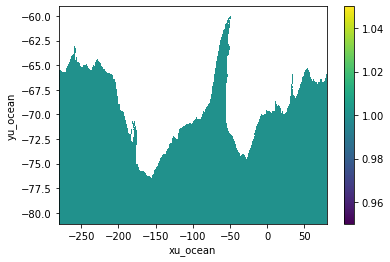

In [131]:
shelf_mask_2.plot()

In [135]:
hu_01 = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc').sel(yu_ocean = shelf_mask_2['yu_ocean'])

In [138]:
shelf_mask_3 = xr.where(np.isnan(hu_01['hu']), np.nan, shelf_mask_2)

In [140]:
shelf_mask_3.to_netcdf('../data/shelf_mask_1500misobath.nc')

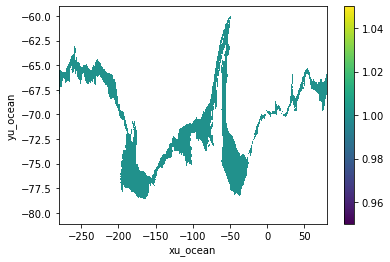

In [142]:
shelf_mask_3.plot()

# In ERA-Int coordinates

In [10]:
era_sst = xr.open_dataset('../data/era-sst-forlandmask.nc')['sst'].isel(time = 0).rename({'longitude':'lon','latitude':'lat'})
era_sst = era_sst.sel(lat = slice(-50, None))

In [40]:
era_sst = era_sst.reindex(lat=era_sst.lat[::-1])

In [41]:
hu = xr.open_dataset('~/g_e14/misc/hu-01deg.nc')['hu']

In [42]:
hu1 = hu.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
hu1['_lon_adj'] = xr.where(hu1['lon'] < 0, hu1['lon'] + 360, hu1['lon'])
hu1 = hu1.swap_dims({'lon': '_lon_adj'})
hu1 = hu1.sel(**{'_lon_adj': sorted(hu1._lon_adj)}).drop('lon')
hu1 = hu1.rename({'_lon_adj': 'lon'})

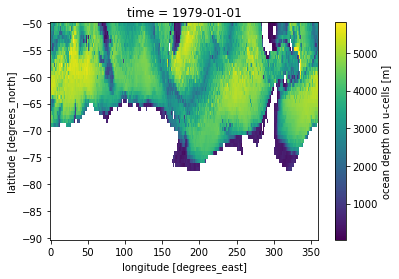

In [49]:
hu1 = hu1.sel(lat = slice(None, -50))
hu1 = hu1.interp(lon = era_sst['lon'], lat = era_sst['lat'])
hu1.plot()

In [75]:
temp_mask = np.copy(hu1.values)
temp_mask[np.where(hu1>2000)] = 0
temp_mask[np.where(hu1<=2000)] = 1

In [76]:
# this spreads the isobath contour so all points are connected adjacently (not just 
# diagonally):
kernel = np.ones((10,10),np.uint8)
contour_mask0 = cv2.dilate(temp_mask,kernel,iterations=1) - temp_mask
print(contour_mask0.shape, contour_mask0.min(), contour_mask0.max())

(54, 480) nan nan


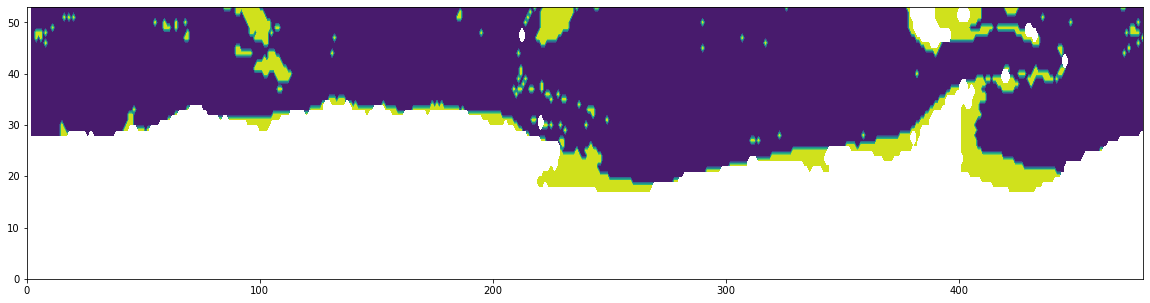

In [77]:
plt.figure(figsize=(20,5))
plt.contourf(temp_mask)

In [78]:
# this spreads the isobath contour so all points are connected adjacently (not just 
# diagonally):
kernel = np.ones((1,1),np.uint8)
contour_mask0 = cv2.dilate(temp_mask,kernel,iterations=1) - temp_mask
print(contour_mask0.shape, contour_mask0.min(), contour_mask0.max())

(54, 480) nan nan


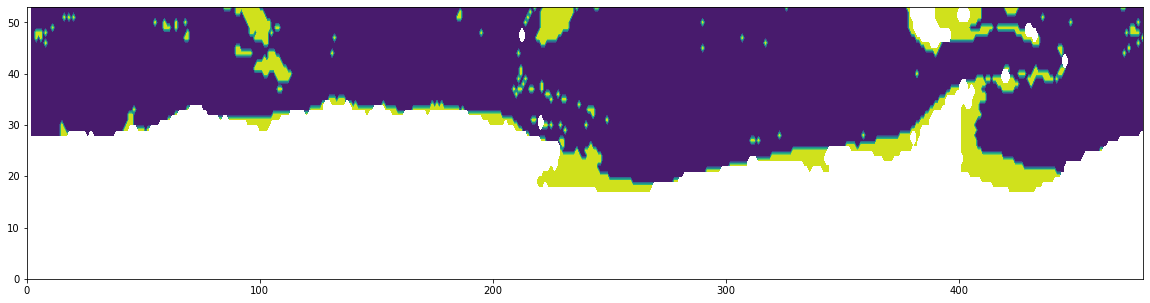

In [79]:
plt.figure(figsize=(20,5))
plt.contourf(temp_mask)

In [121]:
# start at western edge of domain, at y point closest to correct depth contour:
contour_mask = np.zeros_like(land_mask)
contour_lat_index_start = np.where(contour_mask0[:,0]>0)[0][0]
contour_mask[contour_lat_index_start,0] = 1

In [123]:
# loop through to find adjacent point closest to 1000m depth (not inc previous point):
last_index_i = 0
last_index_j = contour_lat_index_start
count = 0
while last_index_i<3599:
    # first time don't go backwards:
    if last_index_i == 0:
        points_to_compare = np.array([contour_mask0[last_index_j,last_index_i+1],
                                      0,
                                      contour_mask0[last_index_j+1,last_index_i],
                                      contour_mask0[last_index_j-1,last_index_i]])
    else:
        points_to_compare = np.array([contour_mask0[last_index_j,last_index_i+1],
                                     contour_mask0[last_index_j,last_index_i-1],
                                     contour_mask0[last_index_j+1,last_index_i],
                                     contour_mask0[last_index_j-1,last_index_i]])

    new_loc = np.where(points_to_compare==1)[0]

    # this gives each point along contour a unique index number:
    if len(new_loc)==0:
        contour_mask[last_index_j,last_index_i] = 0
        contour_mask0[last_index_j,last_index_i] = 0
        #contour_mask0[contour_mask==count] = 0
        #print('j'+str(last_index_j)+'i'+str(last_index_i))
        count = count - 1
        last_index_i = np.where(contour_mask==count+1)[1]
        last_index_j = np.where(contour_mask==count+1)[0]
        continue
    elif len(new_loc)>0:
        if new_loc[0] == 0:
            new_index_i = last_index_i+1
            new_index_j = last_index_j
        elif new_loc[0] == 1:
            new_index_i = last_index_i-1
            new_index_j = last_index_j
        elif new_loc[0] == 2:
            new_index_i = last_index_i
            new_index_j = last_index_j+1
        elif new_loc[0] == 3:
            new_index_i = last_index_i
            new_index_j = last_index_j-1
        contour_mask[new_index_j,new_index_i] = count + 2
        contour_mask0[last_index_j,last_index_i] = 2
        last_index_j = new_index_j
        last_index_i = new_index_i
        count += 1

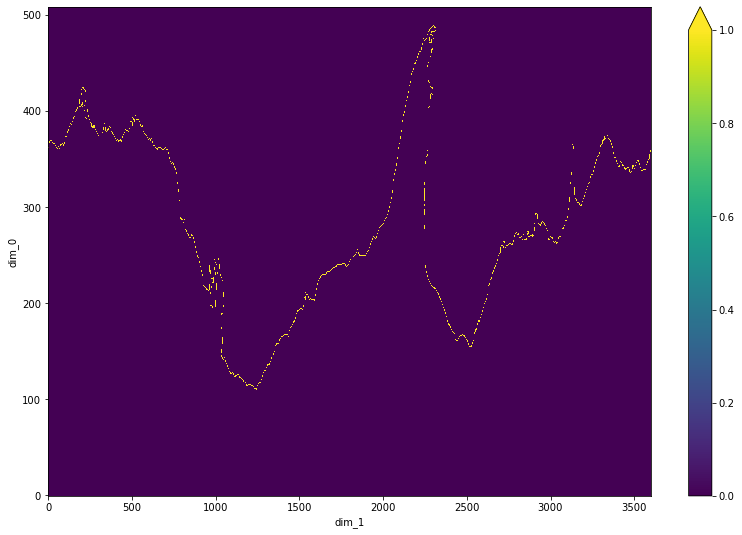

In [124]:
contour_mask0.shape
a = xr.DataArray(contour_mask)
a.plot(size= 9, vmin=0, vmax=1)

In [125]:
contour_mask_numbered = contour_mask

In [126]:
contour_masked_above = np.copy(contour_mask_numbered)
#contour_masked_above[-1,0] = -100

In [127]:
######################
# fill in points to north of contour:
print('Floodfilling above contour')

contour_masked_above = np.copy(contour_mask_numbered)
contour_masked_above[-1,0] = -100

# from top left:
for ii in range(len(xu_ocean)-1):
    for jj in range(len(yu_ocean))[::-1][:-1]:
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj-1,ii] == 0:
                contour_masked_above[jj-1,ii] = -100
            if contour_masked_above[jj,ii+1] == 0:
                contour_masked_above[jj,ii+1] = -100
            if contour_masked_above[jj-1,ii+1] == 0:
                contour_masked_above[jj-1,ii+1] = -100
# from top right:
for ii in range(len(xu_ocean))[::-1][:-1]:
    for jj in range(len(yu_ocean))[::-1][:-1]:
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj-1,ii] == 0:
                contour_masked_above[jj-1,ii] = -100
            if contour_masked_above[jj,ii-1] == 0:
                contour_masked_above[jj,ii-1] = -100
            if contour_masked_above[jj-1,ii-1] == 0:
                contour_masked_above[jj-1,ii-1] = -100
# from bottom right:
for ii in range(len(xu_ocean))[::-1][:-1]:
    for jj in range(len(yu_ocean)-1):
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj+1,ii] == 0:
                contour_masked_above[jj+1,ii] = -100
            if contour_masked_above[jj,ii-1] == 0:
                contour_masked_above[jj,ii-1] = -100
            if contour_masked_above[jj+1,ii-1] == 0:
                contour_masked_above[jj+1,ii-1] = -100
# from bottom left:
for ii in range(len(xu_ocean)-1):
    for jj in range(len(yu_ocean)-1):
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj+1,ii] == 0:
                contour_masked_above[jj+1,ii] = -100
            if contour_masked_above[jj,ii+1] == 0:
                contour_masked_above[jj,ii+1] = -100
            if contour_masked_above[jj+1,ii+1] == 0:
                contour_masked_above[jj+1,ii+1] = -100

Floodfilling above contour


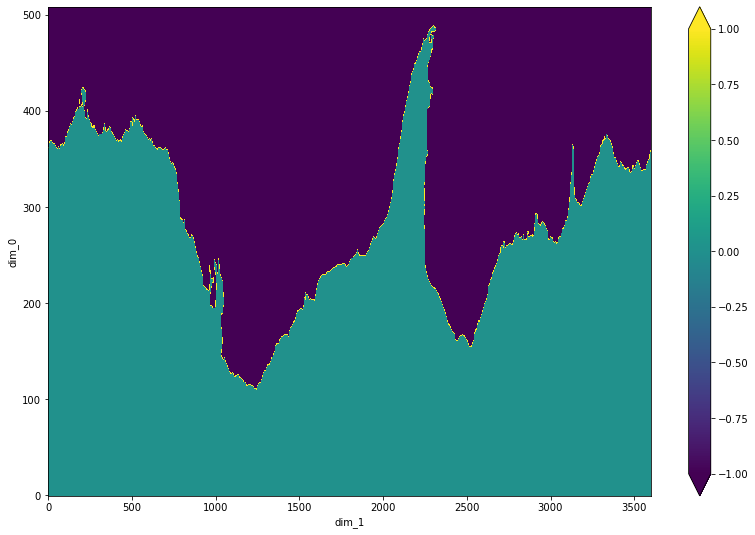

In [128]:
b = xr.DataArray(contour_masked_above)
b.plot(size= 9, vmin=-1, vmax=1)

In [129]:
shelf_mask_1 = xr.where(b==-100, np.nan, 1)

In [130]:
shelf_mask_2 = shelf_mask_1.rename({'dim_0':'yu_ocean', 'dim_1':'xu_ocean'})
shelf_mask_2['xu_ocean'] = xu_ocean
shelf_mask_2['yu_ocean'] = yu_ocean

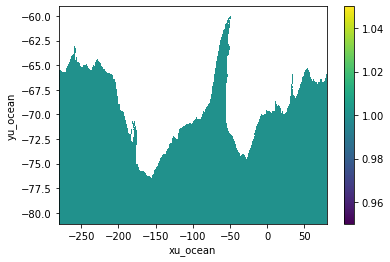

In [131]:
shelf_mask_2.plot()

In [135]:
hu_01 = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc').sel(yu_ocean = shelf_mask_2['yu_ocean'])

In [138]:
shelf_mask_3 = xr.where(np.isnan(hu_01['hu']), np.nan, shelf_mask_2)

In [140]:
shelf_mask_3.to_netcdf('../data/shelf_mask_1500misobath.nc')

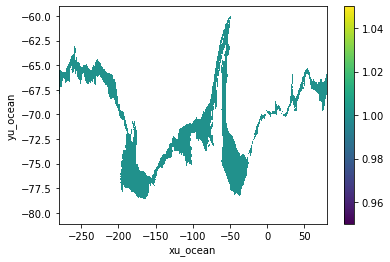

In [142]:
shelf_mask_3.plot()